=== Error‐Tweet Analysis ===
Total tweets: 111
Azure policy blocks: 111 (100.0%)
Connection Error: 0 (0.0%)

Breakdown of policy violations by reason (singles then combos):
Violation Reason  Count  Percentage
  hate, violence      9        8.11
        violence     76       68.47
            hate     31       27.93
          sexual      9        8.11
       self_harm      4        3.60


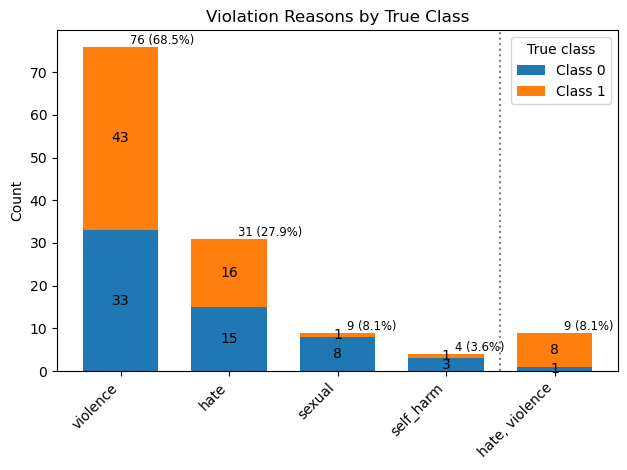

Chart saved to ./AzureAI_4o-miniviolation_reasons_by_class.png

=== Test‐Data Analysis ===
=== Quick Overview ===
Total tweets:              1523
Total unable to classify:  111 (7.3%)
  - Azure policy blocks:   111 (7.3%)
  - Connection errors:      0 (0.0%)
Passed filter:             1412 (92.7%)

Of blocked tweets, labeled=1: 53 (47.7%)



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def load_data(csv_path):
    """
    Load a CSV and normalize column names to the expected schema.
    Supports both raw test data (with 'text' and 'target') and error-tweet data
    (with 'Violation reasons').
    """
    df = pd.read_csv(csv_path)
    # Rename raw test columns
    rename_map = {}
    if 'text' in df.columns:
        rename_map['text'] = 'Original tweet'
    if 'target' in df.columns:
        rename_map['target'] = 'True class'
    if rename_map:
        df = df.rename(columns=rename_map)
    # Ensure 'Violation reasons' exists
    if 'Violation reasons' not in df.columns:
        df['Violation reasons'] = ''
    return df

def compute_summary(df):
    """
    Compute counts of Azure policy flags on df, splitting comma-separated reasons.
    Returns total, passed_mask, passed, blocked, reason_counts (singles+combos),
    and true_distribution (counts by True class for each category).
    """
    total = len(df)

    # Parse reasons into lists
    df['Reason List'] = (
        df['Violation reasons']
        .fillna('')
        .astype(str)
        .apply(lambda x: [s.strip() for s in x.split(',') if s.strip()])
    )

    # conErr vs blocked
    conErr_mask = df['Reason List'].apply(len) == 0
    conErr = conErr_mask.sum()
    blocked = total - conErr

    # Single reason counts
    all_reasons = sorted({r for lst in df['Reason List'] for r in lst})
    single_counts = {
        r: df['Reason List'].apply(lambda lst: r in lst).sum()
        for r in all_reasons
    }

    # Combo counts (only real combos of length >1)
    df['Combo Key'] = df['Reason List'].apply(
        lambda lst: ', '.join(sorted(lst)) if len(lst) > 1 else ''
    )
    combo_series = df.loc[df['Combo Key'] != '', 'Combo Key']
    combo_counts = combo_series.value_counts().to_dict()

    # Build reason_counts DataFrame
    rows = []
    for reason, cnt in single_counts.items():
        rows.append({'Violation Reason': reason, 'Count': cnt, 'Type': 'single'})
    for combo, cnt in combo_counts.items():
        rows.append({'Violation Reason': combo, 'Count': cnt, 'Type': 'combo'})
    reason_counts = pd.DataFrame(rows)
    reason_counts['Percentage'] = (reason_counts['Count'] / total * 100).round(2)
    reason_counts = reason_counts.sort_values(
        by=['Type', 'Count'], ascending=[True, False]
    ).reset_index(drop=True)

    # True class distribution per category
    dist_rows = []
    for cat in reason_counts['Violation Reason']:
        if ', ' in cat:
            mask = df['Combo Key'] == cat
        else:
            mask = df['Reason List'].apply(lambda lst: cat in lst)
        sub = df.loc[mask, 'True class']
        counts = sub.value_counts().to_dict()
        dist_rows.append({
            'Violation Reason': cat,
            0: counts.get(0, 0),
            1: counts.get(1, 0)
        })
    true_distribution = pd.DataFrame(dist_rows).set_index('Violation Reason')

    return {
        'total': total,
        'conErr_mask': conErr_mask,
        'conErr': conErr,
        'blocked': blocked,
        'reason_counts': reason_counts,
        'true_distribution': true_distribution
    }

def print_summary(summary):
    total = summary['total']
    blocked = summary['blocked']
    conErr = summary['conErr']

    print(f"Total tweets: {total}")
    print(f"Azure policy blocks: {blocked} ({blocked/total*100:.1f}%)")
    print(f"Connection Error: {conErr} ({conErr/total*100:.1f}%)\n")

    print("Breakdown of policy violations by reason (singles then combos):")
    rc = summary['reason_counts']
    if rc.empty:
        print("No violations found.")
    else:
        print(rc[['Violation Reason', 'Count', 'Percentage']].to_string(index=False))

def plot_violation_reasons_by_class(summary, output_dir):
    """
    Plot only the stacked‐bar chart of violation reasons by True class,
    with each segment annotated by its count and the total annotated
    at the top‐right of each bar. Combo reasons (containing commas) are
    moved to the end of the x-axis, and a dotted line separates singles vs combos.
    """
    td = summary['true_distribution']

    # reorder reasons: singles first, then combos
    all_reasons = td.index.tolist()
    single_reasons = [r for r in all_reasons if ',' not in r]
    combo_reasons  = [r for r in all_reasons if ',' in r]
    reasons = single_reasons + combo_reasons

    # determine boundary position for the vertical line
    boundary = len(single_reasons) - 0.5

    classes = sorted(td.columns)  # e.g. [0, 1]
    os.makedirs(output_dir, exist_ok=True)
    bar_width = 0.7
    x = list(range(len(reasons)))

    fig, ax = plt.subplots()

    # draw the separation line
    ax.axvline(x=boundary, linestyle=':', linewidth=1.5, color='gray', zorder=0)

    bottoms = None
    # plot each class stack and annotate segment counts
    for cls in classes:
        vals = [td.loc[r, cls] for r in reasons]
        bars = ax.bar(
            x, vals,
            bottom=bottoms,
            width=bar_width,
            label=f'Class {cls}'
        )
        for bar in bars:
            h = bar.get_height()
            if h > 0:
                ax.annotate(
                    f'{int(h)}',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_y() + h/2),
                    xytext=(0, 0),
                    textcoords='offset points',
                    ha='center',
                    va='center'
                )
        bottoms = vals if bottoms is None else [a + b for a, b in zip(bottoms, vals)]

  # # annotate total (and percent of overall tweets) at top‐right of each bar
  #   total_tweets = summary['total']
  #   for i, count in enumerate(bottoms):
  #       pct = count / total_tweets * 100
  #       ax.annotate(
  #           f"{int(count)}",
  #           xy=(i + bar_width/15, count),
  #           xytext=(3, 0),
  #           textcoords='offset points',
  #           ha='left',
  #           va='bottom'
  #       )

      # annotate total (and percent of overall tweets) at top‐right of each bar
    total_tweets = summary['total']
    for i, count in enumerate(bottoms):
        pct = count / total_tweets * 100
        ax.annotate(
            f"{int(count)} ({pct:.1f}%)",
            xy=(i + bar_width/15, count),
            xytext=(3, 0),
            textcoords='offset points',
            fontsize='small',
            ha='left',
            va='bottom'
        )

    #     # annotate total (normal) and percent (smaller) at top‐right of each bar
    # total_tweets = summary['total']
    # for i, count in enumerate(bottoms):
    #     pct = count / total_tweets * 100
    #     x = i + bar_width/15
    #     y = count

    #     # 1) Count in default font
    #     ax.annotate(
    #         f"{int(count)}",
    #         xy=(x, y),
    #         xytext=(3, 0),
    #         textcoords='offset points',
    #         ha='left',
    #         va='bottom'
    #     )

    #     # 2) Percentage in smaller font just below
    #     ax.annotate(
    #         f"({pct:.1f}%)",
    #         xy=(x, y),
    #         xytext=(3, -10),          # shift down 10 points
    #         textcoords='offset points',
    #         ha='left',
    #         va='bottom',
    #         fontsize='small',         # <-- smaller font
    #         color='gray'              # optional: make it lighter
    #     )


    ax.set_xticks(x)
    ax.set_xticklabels(reasons, rotation=45, ha='right')
    ax.set_title('Violation Reasons by True Class')
    ax.set_ylabel('Count')
    ax.legend(title='True class')

    fig.tight_layout()
    out_path = os.path.join(output_dir, f'{current_dir}violation_reasons_by_class.png')
    fig.savefig(out_path)
    plt.show()
    plt.close(fig)

    print(f"Chart saved to {out_path}")

def analyze_data(test_csv, error_csv, outdir):
    """
    Merge test data with Azure filter results, compute summary, metrics, and plot.
    Also prints a quick overview of total vs. unable-to-classify vs. passed tweets,
    plus the percentage of blocked tweets labeled class 1.
    """
    # Load
    df_test = load_data(test_csv)
    df_err  = load_data(error_csv)

    # Quick overview counts
    total = len(df_test)
    total_err = len(df_err)
    # of those errors, policy blocks vs connection errors
    blocked_mask = df_err['Violation reasons'].fillna('').str.strip().ne('')
    blocked = blocked_mask.sum()
    conn_errors = total_err - blocked
    passed = total - total_err

    print("=== Quick Overview ===")
    print(f"Total tweets:              {total}")
    print(f"Total unable to classify:  {total_err} ({total_err/total*100:.1f}%)")
    print(f"  - Azure policy blocks:   {blocked} ({blocked/total*100:.1f}%)")
    print(f"  - Connection errors:      {conn_errors} ({conn_errors/total*100:.1f}%)")
    print(f"Passed filter:             {passed} ({passed/total*100:.1f}%)\n")

    # — new addition: percent of blocked tweets labeled class 1 —
    if 'True class' in df_err.columns and blocked > 0:
        blocked_df = df_err[blocked_mask]
        num_labeled1 = (blocked_df['True class'] == 1).sum()
        pct_labeled1 = num_labeled1 / blocked * 100
        print(f"Of blocked tweets, labeled=1: {num_labeled1} ({pct_labeled1:.1f}%)\n")
    else:
        print("No True class column or no blocked tweets to report on.\n")

    # …the rest of your function (merge/summary/plot) would follow here…



current_dir = os.path.basename(os.path.dirname(os.path.abspath("*")))

def main():


    error_csv = f'{current_dir}_error_tweets.csv'
    test_csv  = '../../data/tweets1523.csv'
    outdir    = '.'

    
    print("=== Error‐Tweet Analysis ===")
    df_err = load_data(error_csv)
    err_summary = compute_summary(df_err)
    print_summary(err_summary)
    plot_violation_reasons_by_class(err_summary, outdir)

    # 2) Test‐data analysis
    print("\n=== Test‐Data Analysis ===")
    analyze_data(test_csv, error_csv, outdir)

if __name__ == '__main__':
    main()
